In [1]:
# Regression Analysis

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-white')

train = pd.read_csv('/home/aakash/Downloads/Taxi_fare/train.csv', nrows = 5000000, parse_dates = ['pickup_datetime']).drop(columns = 'key')
print(train.shape)

(5000000, 7)


In [2]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.000000e+06,5.000000e+06,5.000000e+06,4.999964e+06,4.999964e+06,5.000000e+06
mean,1.134080e+01,-7.250678e+01,3.991974e+01,-7.250652e+01,3.991725e+01,1.684695e+00
std,9.820175e+00,1.280970e+01,8.963509e+00,1.284777e+01,9.486767e+00,1.331854e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.310364e+03,3.457622e+03,3.345917e+03,2.080000e+02


In [4]:
## fare amount is our target variable..
## Now clearly fare amount cannot be negative and passenger count cant be 0..
# Taxi Fare initial charge in only 2.5 dollars.
## New York latitudes are around 74 W and 41 to the North.
train = train[(train['fare_amount'] >= 2.5) & (train['passenger_count'] > 0.0) & 
              ((train['pickup_longitude'] > -78) & (train['pickup_longitude'] < -70)) & 
              ((train['pickup_latitude'] > 37) & (train['pickup_latitude'] < 45)) & 
              ((train['dropoff_longitude'] > -78) & (train['dropoff_longitude'] < -70)) & 
              ((train['dropoff_latitude'] > 37) & (train['dropoff_latitude'] < 45))]
train.shape

(4878498, 7)

In [5]:
train_main = train.copy()

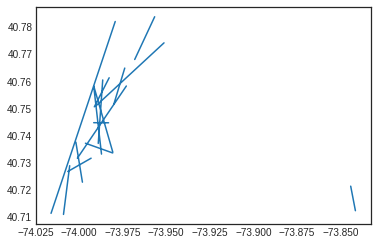

In [6]:
## EDA
## lets view several taxi rides..
lats = []
longs = []
def rides(train, numlines):
    goodrows = train[train['pickup_longitude'] < -70]
    for iterr, row in goodrows[:numlines].iterrows():
        longs.append(row['pickup_longitude'])
        longs.append(row['dropoff_longitude'])
        longs.append(None)
        lats.append(row['pickup_latitude'])
        lats.append(row['dropoff_latitude'])
        lats.append(None)

rides(train, 15)        
plt.plot(longs, lats)        

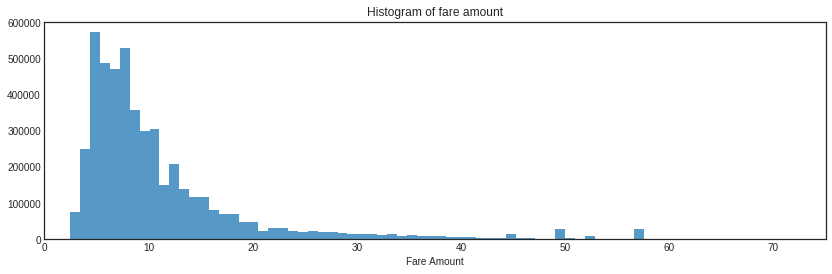

In [7]:
## Fare Amount
plt.figure(figsize = (14,4))
plt.hist(train.fare_amount, bins = 1000, alpha = 0.75)
plt.title('Histogram of fare amount')
plt.xlabel('Fare Amount')
plt.xlim(0, 75)
plt.show()

In [8]:
train.groupby('fare_amount').size().nlargest(10)
## Most common fare amount

fare_amount
6.5     237317
4.5     200433
8.5     183203
5.7     142304
5.3     142293
6.1     138084
4.9     138049
6.9     127239
10.5    124046
7.3     119606
dtype: int64

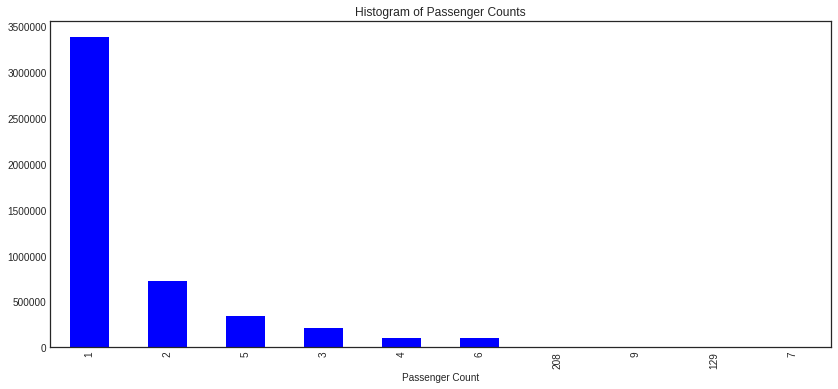

In [9]:
## Histogram of Passenger Counts
plt.figure(figsize = (14,6))
train['passenger_count'].value_counts().plot.bar(color = 'b')
plt.title('Histogram of Passenger Counts')
plt.xlabel('Passenger Count')
plt.show()

In [10]:
## Passenger Count
train.groupby('passenger_count').size().nlargest(10)
## Most passengers travel alone

passenger_count
1      3386066
2       723885
5       346169
3       214918
4       103907
6       103547
9            2
208          2
7            1
129          1
dtype: int64

In [11]:
train = train.loc[train['passenger_count'] <= 6]

In [12]:
## Predictive Modelling
## A Baseline MOdel
import shutil
from sklearn.model_selection import train_test_split

train_x, test_x = train_test_split(train, test_size = 0.3, random_state = 45) 

def distance_bw(lat1, lon1, lat2, lon2):
    # Haversine formula
    dist = np.degrees(np.arccos(np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1))))
    dist *= 60*1.515*1.609344
    return dist

def estimate_dist(df):
    return distance_bw(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'],
                       df['dropoff_longitude'])

def rmse(actual, pred):
    return np.sqrt(np.mean((actual - pred)**2))

def print_rmse(df, rate, name):
    print("{1} RMSE - {0}".format(rmse(df['fare_amount'], rate*estimate_dist(df)), name))


rate = train_x['fare_amount'].mean()/estimate_dist(train_x).mean()
print_rmse(train_x, rate, 'Train')
print_rmse(test_x, rate, 'Test')

/home/aakash/miniconda3/envs/datapysci/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in arccos
  # Remove the CWD from sys.path while we load stuff.


Train RMSE - 9.777305780704962
Test RMSE - 10.202093175504126


In [13]:
## Feature Engineering
## Taxi Fare might be more on certain holidays
train['year'] = train.pickup_datetime.dt.year
train['month'] = train.pickup_datetime.dt.month
train['day'] = train.pickup_datetime.dt.day
train['weekday'] = train.pickup_datetime.dt.week
train['hour'] = train.pickup_datetime.dt.hour

In [14]:
train = train.drop('pickup_datetime', axis = 1)
# the distance from pickup to dropoff location,, The greater circle distance bw two points.
from math import radians, cos, sin, asin, sqrt
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # 6371 is Radius of earth in kilometers. Use 3956 for miles
    return km

In [15]:
train['distance'] = haversine_np(train['pickup_latitude'], train['pickup_longitude'], train['dropoff_latitude'],
                                   train['dropoff_longitude'])

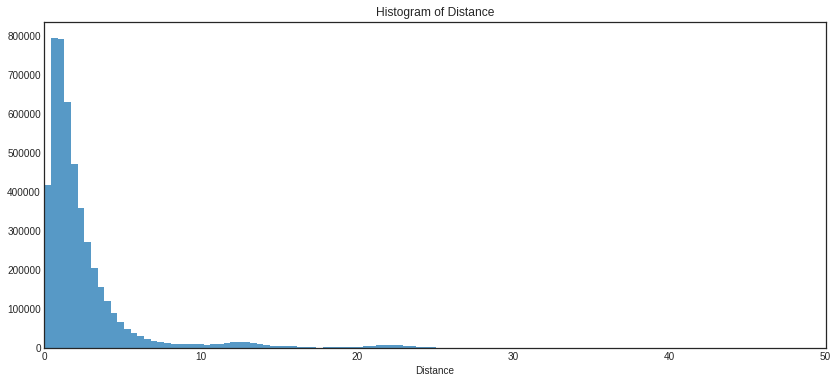

In [16]:
## Histogram for distance
plt.figure(figsize = (14,6))
plt.hist(train.distance, bins = 1000, alpha = 0.75)
plt.title('Histogram of Distance')
plt.xlabel('Distance')
plt.xlim(0, 50)
plt.show()

In [20]:
train = train[train['distance'] > 0.0]
train_main2 = train.copy()

In [22]:
## Machine Learning Models
# Linear Regression
from sklearn.linear_model import LinearRegression

y = train.fare_amount
train = train.drop('fare_amount', axis = 1)

train_x, test_x, train_y, test_y = train_test_split(train, y, test_size = 0.3, random_state = 44) 
## Fare Amount is our target variable
lm = LinearRegression()
lm.fit(train_x, train_y)
y_pred = lm.predict(test_x)

from sklearn.metrics import mean_squared_error

print('Test RMSE %.3f'%(np.sqrt(mean_squared_error(y_pred, test_y))))

Test RMSE 6.116


In [ ]:
## Random Forest Regression 
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth = 2, random_state = 0, n_estimators = 1000)
rf.fit(train_x, train_y)
rf_pred = rf.predict(test_x)
print('Test RMSE %.3f'%(np.sqrt(mean_squared_error(rf_pred, test_y))))

In [26]:
##### Light GBM
import lightgbm as lgb

params = {
    'learning_rate' : 0.75,
    'application' : 'regression',
    'max_depth' : 3,
    'num_leaves' : 100,
    'verbosity' : -1,
    'metric' : 'RMSE'
}
train_set = lgb.Dataset(train_x, train_y, silent = True)
lb = lgb.train(params, train_set, num_boost_round = 300)
lb_pred = lb.predict(test_x, num_iteration = lb.best_iteration)
print('Test RMSE %.3f'%(np.sqrt(mean_squared_error(lb_pred, test_y))))

Test RMSE 3.692


In [ ]:
#### Using Keras Regression model ####
from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def baseline_model():
    model = Sequential()
    model.add(Dense(11, input_dim = 11,  kernel_initializer='normal', activation = 'relu'))
    model.add(Dense(1,  kernel_initializer='normal'))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return model

np.random.seed(5)

## Evaluating model with standardised dataset
estimator = KerasRegressor(build_fn = baseline_model, batch_size = 5, nb_epoch = 100, verbose = 0)
Kfold = KFold(n_splits = 10, random_state = 5)
results = cross_val_score(estimator, train.values, y.values, cv=Kfold, n_jobs=1)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

estimator.fit(train_x, train_y)
keras_pred = estimator.predict(test_x)
print('Test RMSE %.3f'%(np.sqrt(mean_squared_error(keras_pred, test_y))))